In [1]:
import numpy as np
from numpy import savetxt
import pandas as pd
import math
import os

In [2]:
def list_files(filepath, filetype):
    count = 0
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if file.lower().endswith(filetype.lower()):
                count = count + 1
    return(count)

In [3]:
def parse_patient_information(sn_num):
    samples_per_hour = 1080000 # sample rate is 300Hz
    samples_per_min = int(samples_per_hour / 60)
    
    # parse the large data by one hour per file
    interval = samples_per_hour
    offset = 0
    count = 1

    ascii_grid = np.loadtxt("SN_" + sn_num + ".asc", skiprows=2)
    while offset + interval < len(ascii_grid) :
        output_data = []
        for i in range(interval):
            output_data.append(float("{0:.3f}".format(ascii_grid[i + offset][1])))    
        output_name = 'data_' + sn_num + '/' + str(count) + '_data.csv'
        savetxt(output_name, output_data, delimiter=',')
        offset = offset + interval
        count = count + 1

In [4]:
def avg_one_min_for_each_patient(sn_num):
    samples_per_hour = 1080000 # sample rate is 300Hz
    samples_per_min = int(samples_per_hour / 60)
        
    # get the average data of one miniute for a sn
    dir_name = "data_" + sn_num

    file_count = list_files(dir_name, '.csv')
    output_data = []
    for i in range(file_count):
        data = pd.read_csv('data_' + sn_num + '/' + str(i + 1) + '_data.csv', header = None)
        offset = 0
        X = data.iloc[:,0]  #independent columns
        while offset + samples_per_min <= len(X):
            output_data.append(float("{0:.2f}".format(np.mean(data.iloc[offset: offset + samples_per_min, 0]))))
            offset = offset + samples_per_min
    output_name = 'SN_' + sn_num + '_per_min.csv'
    savetxt(output_name, output_data, delimiter=',')

In [5]:
# parse_patient_information("34") # "40", "41", "42", "43"
# avg_one_min_for_each_patient("34") # "40", "41", "42", "43"

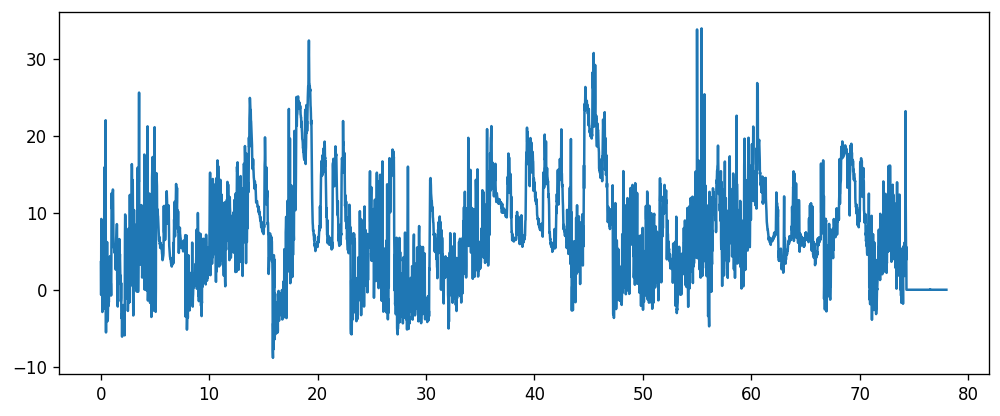

In [6]:
# plotting the points 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 4), dpi=120, facecolor='w', edgecolor='k')

sn_num = "43"
data = pd.read_csv('SN_' + sn_num + '_per_min.csv', header = None)
x = []
for i in range(len(data)):
    x.append((i + 1)/60) 
plt.plot(x, data) 
plt.show()

In [7]:
#x_train, x_test, y_train, y_test
#sn_num = "34"
#data = pd.read_csv('SN_' + sn_num + '_per_min.csv', header = None)


In [8]:
def check_ICP(num):
    if num > 13:
        return 1
    elif num < 6:
        return 1
    else:
        return 0

In [9]:
num = len(data)
num_train = int(num * 0.8) # 0.8 usually
num_test = num - num_train
samples_four_hours = 60 * 4
interval = 30
offset = 0
index_train = 0
index_test = num_train
x_train = []
y_train = []
x_test = []
y_test = []
# 0 + 240 + 30 = 270
while index_train + samples_four_hours + interval < num_train:
    x_data = []
    for i in range(samples_four_hours):
        x_data.append(data[0][index_train + i])
    x_train.append(x_data)
    y_train.append(check_ICP(data[0][index_train + samples_four_hours + interval]))
    #y_train.append(1)
    index_train = index_train + 1

while index_test + samples_four_hours + interval < num:
    x_data = []
    for i in range(samples_four_hours):
        x_data.append(data[0][index_test + i])
    x_test.append(x_data)
    y_test.append(check_ICP(data[0][index_test + samples_four_hours + interval]))
    index_test = index_test + 1


In [10]:
import tensorflow as tf

import math
import json
import sys

import keras
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
from keras.layers import Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import initializers
from keras.engine import Layer, InputSpec
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import *
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import argparse

import time
from datetime import timedelta


def build_model(SHAPE, nb_classes, seed=None):
    if seed:
        np.random.seed(seed)

    input_layer = Input(shape=SHAPE)

    # Step 1
    x = Conv1D(32, 3, activation='relu')(input_layer)

    # Step 2 - Pooling
    x = MaxPooling1D(pool_size=2)(x)

    # Step 1
    x = Conv1D(48, 3, activation='relu')(x)
    # Step 2 - Pooling
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)

    # Step 1
    x = Conv1D(64, 3, activation='relu')(x)
    # Step 2 - Pooling
    x = MaxPooling1D(pool_size=2)(x)

    # Step 1
    x = Conv1D(96, 3, activation='relu')(x)
    # Step 2 - Pooling
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)

    # Step 3 - Flattening
    x = Flatten()(x)

    # Step 4 - Full connection

    x = Dense(output_dim=256, activation='relu')(x)
    # Dropout
    x = Dropout(0.5)(x)

    x = Dense(output_dim=2, activation='softmax')(x)

    model = Model(input_layer, x)

    return model

Using TensorFlow backend.


In [11]:
SHAPE = (samples_four_hours, 1)
model = build_model(SHAPE, 2)

/opt/anaconda3/envs/AndrewTensorFlowEnv/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
/opt/anaconda3/envs/AndrewTensorFlowEnv/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`


In [12]:
#model.compile(optimizer=Adam(lr=1.0e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# fit data
X = np.array(x_train)
Y = np.array(y_train)
from keras.utils import to_categorical
Y = to_categorical(Y)
X = X.reshape((X.shape[0], X.shape[1], 1))
model.fit(X, Y, batch_size=50, epochs=100)

# make prediction
X_test = np.array(x_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)

# calculate accuracy
y_pred = np.argmax(predicted, axis=1)

#Y_test = np.array(y_train)
Y_test = np.array(y_test)
from keras.utils import to_categorical
Y_test = to_categorical(Y_test)
Y_test = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred)
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn)), 3)

Epoch 1/100
3474/3474 [==============================] - 4s 1ms/step - loss: 0.7005 - accuracy: 0.5984
Epoch 2/100
3474/3474 [==============================] - 3s 750us/step - loss: 0.6504 - accuracy: 0.6114
Epoch 3/100
3474/3474 [==============================] - 3s 749us/step - loss: 0.6323 - accuracy: 0.6244
Epoch 4/100
3474/3474 [==============================] - 3s 797us/step - loss: 0.6113 - accuracy: 0.6543
Epoch 5/100
3474/3474 [==============================] - 3s 770us/step - loss: 0.5867 - accuracy: 0.6842
Epoch 6/100
3474/3474 [==============================] - 3s 737us/step - loss: 0.5630 - accuracy: 0.7058
Epoch 7/100
3474/3474 [==============================] - 3s 735us/step - loss: 0.5356 - accuracy: 0.7188
Epoch 8/100
3474/3474 [==============================] - 3s 747us/step - loss: 0.5120 - accuracy: 0.7427
Epoch 9/100
3474/3474 [==============================] - 3s 778us/step - loss: 0.5037 - accuracy: 0.7461
Epoch 10/100
3474/3474 [==============================] -

3474/3474 [==============================] - 3s 780us/step - loss: 0.0882 - accuracy: 0.9652
Epoch 79/100
3474/3474 [==============================] - 3s 777us/step - loss: 0.0987 - accuracy: 0.9597
Epoch 80/100
3474/3474 [==============================] - 3s 795us/step - loss: 0.0911 - accuracy: 0.9632
Epoch 81/100
3474/3474 [==============================] - 3s 798us/step - loss: 0.0905 - accuracy: 0.9649
Epoch 82/100
3474/3474 [==============================] - 3s 803us/step - loss: 0.0882 - accuracy: 0.9663
Epoch 83/100
3474/3474 [==============================] - 3s 800us/step - loss: 0.0896 - accuracy: 0.9620
Epoch 84/100
3474/3474 [==============================] - 3s 801us/step - loss: 0.1083 - accuracy: 0.9597
Epoch 85/100
3474/3474 [==============================] - 3s 805us/step - loss: 0.0942 - accuracy: 0.9660
Epoch 86/100
3474/3474 [==============================] - 3s 804us/step - loss: 0.0828 - accuracy: 0.9675
Epoch 87/100
3474/3474 [==============================] - 3

In [14]:
accuracy

0.617

In [15]:
TPR

0.7712031558185405

In [16]:
FPR

0.8742138364779874

In [17]:
len(x_train)

3474

In [18]:
len(x_test)

666

In [19]:
len(data)

4680

In [20]:
Y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [21]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,